### Electric field of a parallel-plate capacitor

Consider the electric potential and electric field in a grounded square box with two parallel plates, each half the length of the box, and spaced evenly at 1/3 and 2/3 the width of the box. The left plate is held at -1V and the right at 1V. The expected behavior of the electric field would be to point outward from the positive plate and inward to the negative plate, with the field between the plates pointing in straight lines perpendicular to the plates. Were the plates to be moved closer together, we could expect the gradient to become steeper but generally the behavior will remain the same.

Here we will use the Jacobi method for relaxation and the Gauss-Seidel method for simultaneous overrelaxation.

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [4]:
def nn(box,i,j):
    # takes in an array and a 'coordinate'
    # returns the sum of the nearest neighbors
    return box[i-1,j] + box[i+1,j] + box[i,j-1] + box[i,j+1]

def jacobi(N,epsilon,y0,y1,x0,x1):
    # Jacobi method for relaxation
    # takes in a grid size N, an error threshold epsilon,
    # and position data for the plates
    # returns the relaxed array and the number of steps taken
    
    # generate the array that represents the potential field
    box = np.zeros((N+1,N+1),float)
    box[y0:y1,x0] = -1
    box[y0:y1,x1] = 1
    
    # generate the array to hold the next step
    boxprime = np.empty((N+1,N+1),float)
    
    k = 0
    delta = 1.0
    while delta >= epsilon:
        for i in range(N+1):
            for j in range(N+1):
                # if the coordinate is on the edge or one of the
                # plates, change nothing
                if i == 0 or i == N or j == 0 or j == N or \
                i > y0 and i < y1 and (j == x0 or j == x1):
                    boxprime[i,j] = box[i,j]
                # otherwise, set equal to average of nearest neighbors
                else:
                    boxprime[i,j] = nn(box,i,j)/4
        delta = np.max(abs(box-boxprime))
        box,boxprime = boxprime,box
        k += 1
        
    return box, k

def sor(N,epsilon,weight,y0,y1,x0,x1):
    # Gauss-Seidel method for overrelaxation
    # takes in a grid size N, an error threshold epsilon,
    # a weight, and position data for the plates
    # returns the relaxed array and the number of steps taken
    
    # generate the array that represents the potential field
    box = np.zeros((N+1,N+1),float)
    box[y0:y1,x0] = -1
    box[y0:y1,x1] = 1
    
    # generate the array to hold the previous step,
    # which we use strictly for the convergence criterion
    oldbox = np.empty((N+1,N+1),float)
        
    k = 0
    delta = 1.0
    while delta >= epsilon:
        # set the previous step equal to the current step
        oldbox[:,:] = box[:,:]
        for i in range(N+1):
            for j in range(N+1):
                # if the coordinate is on the edge or one of the
                # plates, change nothing
                if i == 0 or i == N or j == 0 or j == N or \
                (i > y0 and i < y1 and (j == x0 or j == x1)):
                    continue
                # otherwise, set it equal to the weighted average of
                # the nearest neighbors minus the weighted self.
                else:
                    box[i,j] = weight*nn(box,i,j)/4 + (1-weight)*box[i,j]
        delta = np.max(abs(box-oldbox))
        k += 1

    return box, k

steps : weight
--------------
1740 : 1.0
1662 : 1.0263157894736843
1587 : 1.0526315789473684
1516 : 1.0789473684210527
1447 : 1.1052631578947367
1380 : 1.131578947368421
1317 : 1.1578947368421053
1256 : 1.1842105263157894
1197 : 1.2105263157894737
1140 : 1.236842105263158
1085 : 1.263157894736842
1032 : 1.2894736842105263
980 : 1.3157894736842106
930 : 1.3421052631578947
882 : 1.368421052631579
835 : 1.3947368421052633
790 : 1.4210526315789473
746 : 1.4473684210526314
703 : 1.4736842105263157
661 : 1.5


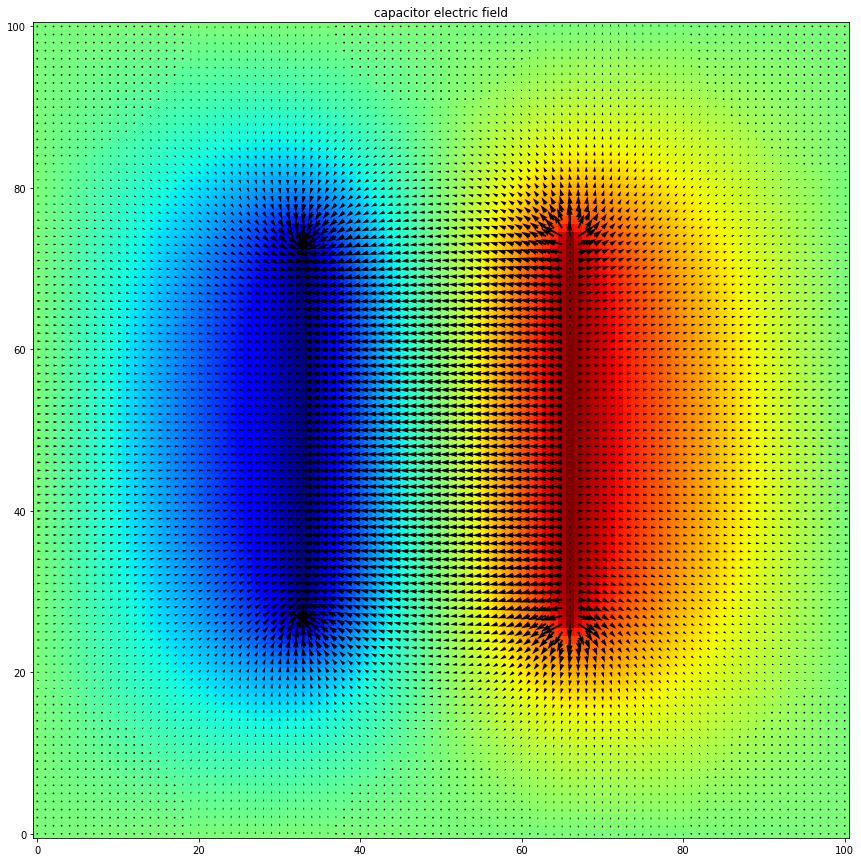

In [5]:
N = 100
epsilon = 1e-6

y0 = N//4   # sets the
y1 = y0*3   # coordinates
x0 = N//3   # of the
x1 = x0*2   # plates

# iterate through a span of weights, storing the weight
# and the steps taken for that weight in a dictionary
weights = {}
print("steps : weight\n--------------")
for weight in np.linspace(1,1.5,20,True):
    box, k = sor(N,epsilon,weight,y0,y1,x0,x1)
    weights[weight] = k
    print(k, ":", weight)

# get the weight associated with the minimum steps taken
w = min(weights, key=weights.get)

# run the relaxation again with the optimized weight
box,k = sor(N,epsilon,w,y0,y1,x0,x1)
x,y = np.meshgrid(np.arange(0,N+1,1),np.arange(0,N+1,1))
v,u = np.gradient(box)

plt.figure(figsize=(15,15))
plt.title("capacitor electric field")
plt.imshow(box,cmap=plt.get_cmap('jet'))
plt.quiver(x,y,-u,-v)
plt.gca().invert_yaxis()
plt.show()

From this experiment we can see that the optimal weight is 1.5. By my own experimentation, I have found even better weights outside the range of (1,1.5] but the question limits our search to this range, so we will use 1.5 as our weight from here forward. An investigation into the relationship between grid size and optimal weight may prove interesting.

N: 50 
k1: 1055  k2: 207
N: 100 
k1: 3304  k2: 661
N: 200 
k1: 10368  k2: 2227
N: 400 
k1: 31049  k2: 7117


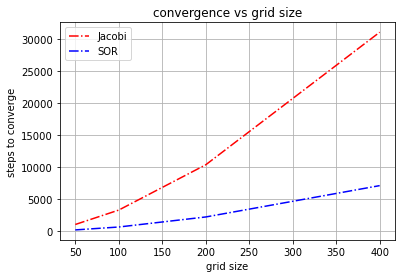

In [6]:
grid_sizes = [50,100,200,400]
jacobi_steps = []
sor_steps = []

# iterate through grid sizes and accumulate the number of steps
# to reach convergence for each grid size for each method
for N in grid_sizes:
    y0 = N//4
    y1 = y0*3
    x0 = N//3
    x1 = x0*2
    box1,k1 = jacobi(N,epsilon,y0,y1,x0,x1)
    jacobi_steps.append(k1)
    box2,k2 = sor(N,epsilon,w,y0,y1,x0,x1)
    sor_steps.append(k2)
    print("N:",N,"\nk1:",k1," k2:",k2)

l1,l2 = plt.plot(grid_sizes,jacobi_steps,'-.r',grid_sizes,sor_steps,'-.b')
plt.grid()
plt.title("convergence vs grid size")
plt.xlabel("grid size")
plt.ylabel("steps to converge")
plt.legend((l1,l2),('Jacobi','SOR'))
plt.show()

We can see that the performance of the Gauss-Seidel method is vastly better than that of the Jacobi method - on the order of five or six times fewer steps. There is a quadratic relation between grid size and steps to converge, so we can investigate the order of the relation with a log-log linear regression.

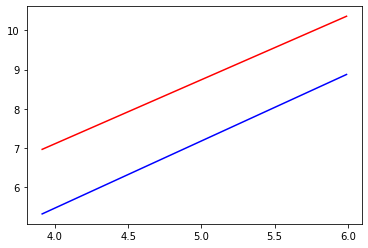

Order of the Jacobi method: 1.628754773159729
Order of the Gauss-Seidel method: 1.7063079070671543


In [21]:
fit_jacobi = linregress(np.log(grid_sizes),np.log(jacobi_steps))
fit_sor = linregress(np.log(grid_sizes),np.log(sor_steps))
x_fit = np.log(np.linspace(50,400,100))
l1, = plt.plot(x_fit,fit_jacobi.slope*x_fit+fit_jacobi.intercept,'-r')
l2, = plt.plot(x_fit,fit_sor.slope*x_fit+fit_sor.intercept,'-b')
plt.show()
print("Order of the Jacobi method:",fit_jacobi.slope)
print("Order of the Gauss-Seidel method:",fit_sor.slope)

Interestingly, the Jacobi and Gauss-Seidel methods have very similar order, which is entirely different from what I would have expected; however, the Jacobi method begins with a larger convergence time, so with that knowledge we can see that the relationship of the order of growth reflects our observed data.

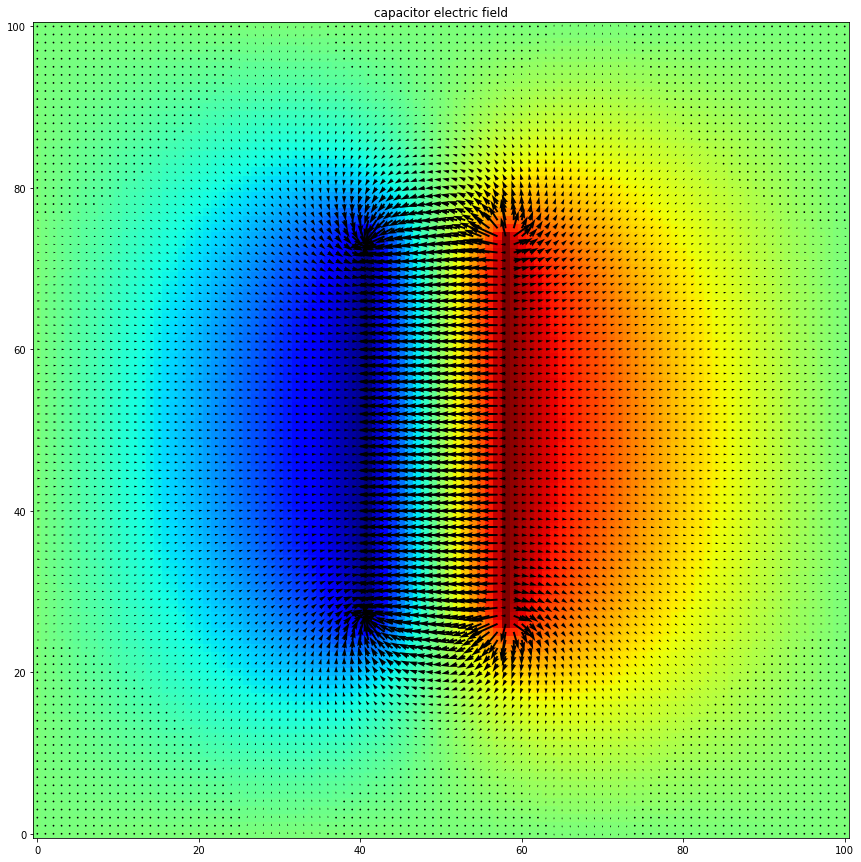

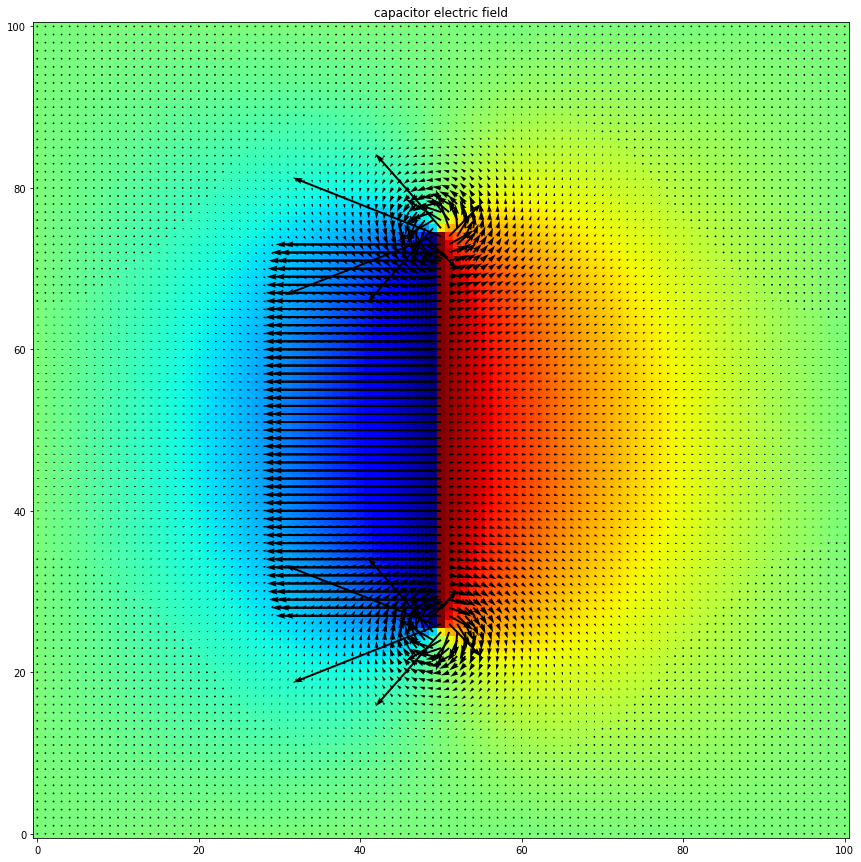

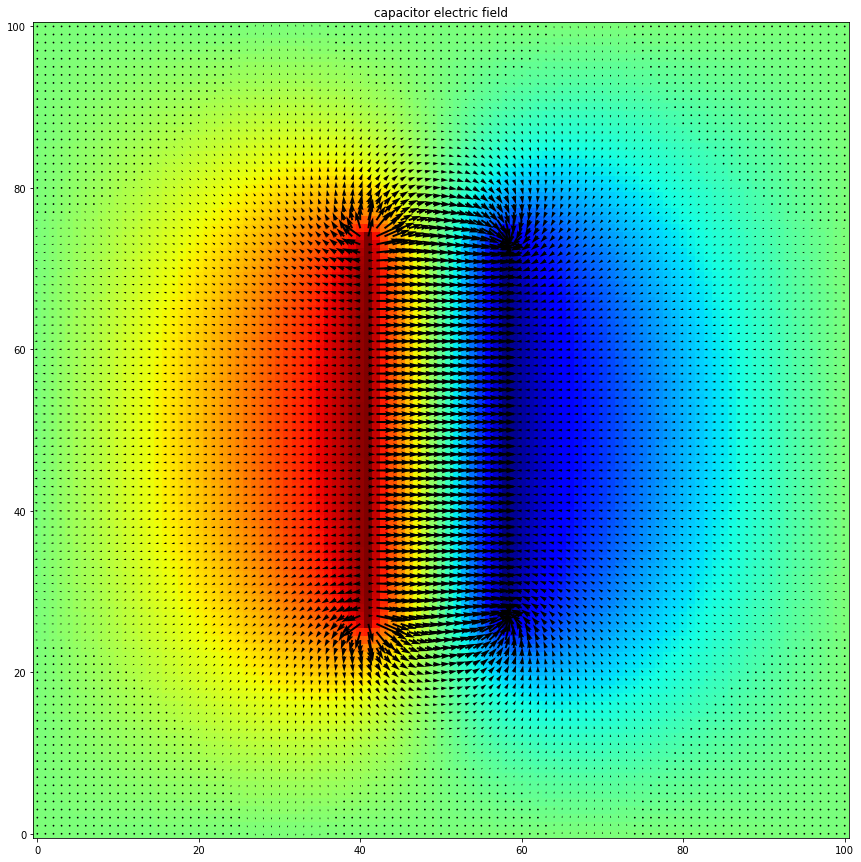

In [7]:
N = 100

y0 = N//4
y1 = y0*3
x0 = N//3
x1 = x0*2

# iterate through three plate positions as we move them closer
# together and eventually past each other.
for i in range(1,4):
    box,k = sor(N,epsilon,w,y0,y1,x0+i*N//12,x1-i*N//12)
    x,y = np.meshgrid(np.arange(0,N+1,1),np.arange(0,N+1,1))
    v,u = np.gradient(box)

    plt.figure(figsize=(15,15))
    plt.title("capacitor electric field")
    plt.imshow(box,cmap=plt.get_cmap('jet'))
    plt.quiver(x,y,-u,-v)
    plt.gca().invert_yaxis()
    plt.show()

We can see that the behavior of the electric field is indeed as expected as we move the plates closer together. With the plates adjacent, we can see some interesting unphysical behavior which may indicate numerical instability.